Run in Colab

In [1]:
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/data/labelled_training_data.csv')
df_valid = pd.read_csv('/content/drive/MyDrive/data/labelled_validation_data.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/labelled_testing_data.csv')

In [34]:
def preprocess(df):
    # Provided by BETH author (Highman 2021)
    df_preprocessed = pd.DataFrame(df[['processId', 'parentProcessId', 'userId', 'mountNamespace', 'eventId', 'stackAddresses', 'returnValue']])

    # Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['processId'] = df['processId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # Parent Process IDs: Map to 0 for OS processes, else 1
    df_preprocessed['parentProcessId'] = df['parentProcessId'].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS

    # User IDs: Map to 1 for users with IDs < 1000 (likely OS users), else 0
    df_preprocessed['userId'] = df['userId'].map(lambda x: 1 if x < 1000 else 0)  # Map to OS users

    # Namespace IDs: Check for specific value (402653184) for certain processes, else map to 0
    df_preprocessed['mountNamespace'] = df['mountNamespace'].map(lambda x: 0 if x == 402653184 else 1)  # Check for OS processes

    # Event IDs: Keep event IDs as is (assuming we need to know the maximum value) One-hot coding(?)
    df_preprocessed['eventId'] = df['eventId']

    # Convert the 'stackAddresses' list of addresses to the number of addresses
    df_preprocessed['stackAddresses'] = df['stackAddresses'].apply(lambda x: len(ast.literal_eval(x)) if x else 0)

    # Return Value: Map returnValue to 0 for 'failure', 1 for 'success', or 2 for unknown
    df_preprocessed['returnValue'] = df['returnValue'].map(lambda x: 0 if x == 0 else (1 if x == 1 else 2))

    return df_preprocessed

In [4]:
X_train = preprocess(df_train)
X_valid = preprocess(df_valid)
X_test = preprocess(df_test)

In [5]:
y_train = df_train['evil']
y_valid = df_valid['evil']
y_test = df_test['evil']

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Build Autoencoder
model = Sequential([
    Dense(64, activation='relu', input_dim = X_train_scaled.shape[1]),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(X_train_scaled.shape[1], activation = 'sigmoid')
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train autoencoder
model.fit(X_train_scaled, X_train_scaled, epochs=20, batch_size=256, validation_split=0.1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6784 - val_loss: 0.5251
Epoch 2/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6372 - val_loss: 0.5251
Epoch 3/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6285 - val_loss: 0.5251
Epoch 4/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6285 - val_loss: 0.5251
Epoch 5/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.6249 - val_loss: 0.5251
Epoch 6/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.6308 - val_loss: 0.5251
Epoch 7/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.6238 - val_loss: 0.5251
Epoch 8/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6349 - val_loss: 0.5251
Epoch 9/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6269 - val_loss: 0.5251
Epoch 10/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.6182 - val_loss: 0.5252
Epoch 11/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6261 - val_loss: 0.5257
Epoch 12/20
2683/2683 ━

In [7]:
# Calculate the threshold from the training data
reconstruction_error_train = np.mean(np.abs(X_train_scaled - model.predict(X_train_scaled)), axis=1)
threshold = np.percentile(reconstruction_error_train, 95)

# Scale test data
X_test_scaled = scaler.transform(X_test)

# Predict the reconstruction of the test data
reconstructed_test = model.predict(X_test_scaled)

# Calculate the reconstruction error for each test data point
reconstruction_error_test = np.mean(np.abs(X_test_scaled - reconstructed_test), axis=1)

# Classify test data points as anomalies (1) or normal (0)
predictions = (reconstruction_error_test > threshold).astype(int)

23849/23849 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Precision: 0.9580643196491655
Recall: 0.9928234195112099
F1-Score: 0.9751342169541121
ROC-AUC: 0.8836722304695397


In [9]:
# Generate classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     30535
           1       0.96      0.99      0.98    158432

    accuracy                           0.96    188967
   macro avg       0.96      0.88      0.92    188967
weighted avg       0.96      0.96      0.96    188967



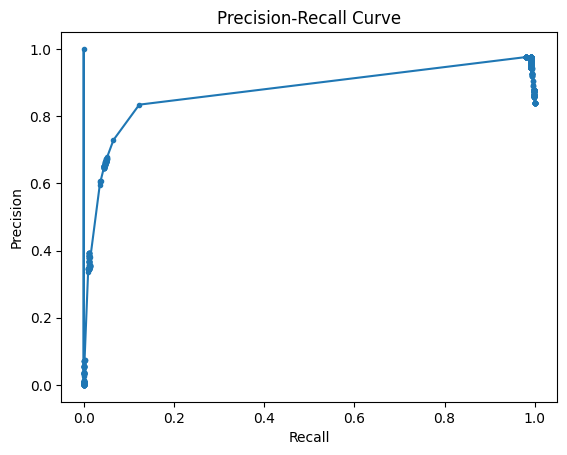

In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

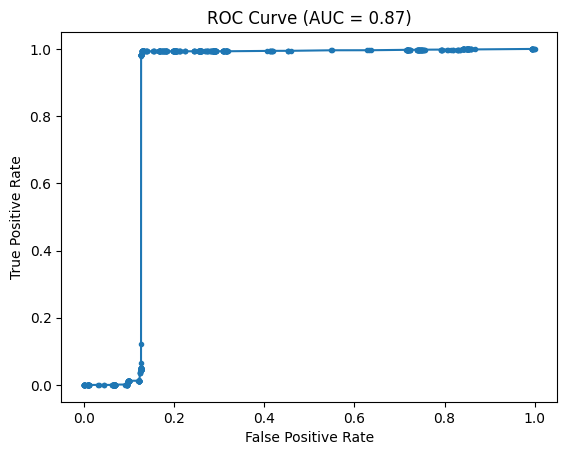

In [11]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, reconstruction_error_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, reconstruction_error_test)

# Plot the ROC curve
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')  # Display the AUC score on the title

# Show the plot
plt.show()

With 3 Features

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['processId', 'parentProcessId', 'userId']])

# Build Autoencoder
model_3 = Sequential([
    Dense(64, activation='relu', input_dim = X_train_scaled.shape[1]),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(X_train_scaled.shape[1], activation = 'sigmoid')
])

model_3.compile(optimizer='adam', loss='mean_squared_error')

# Train autoencoder
model_3.fit(X_train_scaled, X_train_scaled, epochs=20, batch_size=256, validation_split=0.1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2683/2683 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.9510 - val_loss: 0.8804
Epoch 2/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.9721 - val_loss: 0.8804
Epoch 3/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.9579 - val_loss: 0.8804
Epoch 4/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.9629 - val_loss: 0.8804
Epoch 5/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.9553 - val_loss: 0.8804
Epoch 6/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.9568 - val_loss: 0.8804
Epoch 7/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.9675 - val_loss: 0.8804
Epoch 8/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.9900 - val_loss: 0.8804
Epoch 9/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.9636 - val_loss: 0.8803
Epoch 10/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.9622 - val_loss: 0.8803
Epoch 11/20
2683/2683 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.9845 - val_loss: 0.8803
Epoch 12/20
2683/2683 ━━━━━━━━━━━━

In [13]:
# Calculate the threshold from the training data
reconstruction_error_train = np.mean(np.abs(X_train_scaled - model_3.predict(X_train_scaled)), axis=1)
threshold = np.percentile(reconstruction_error_train, 95)

# Scale test data
X_test_scaled = scaler.transform(X_test[['processId', 'parentProcessId', 'userId']])

# Predict the reconstruction of the test data
reconstructed_test = model_3.predict(X_test_scaled)

# Calculate the reconstruction error for each test data point
reconstruction_error_test = np.mean(np.abs(X_test_scaled - reconstructed_test), axis=1)

# Classify test data points as anomalies (1) or normal (0)
predictions = (reconstruction_error_test > threshold).astype(int)

23849/23849 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
5906/5906 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Precision: 0.9618489121528245
Recall: 0.9928234195112099
F1-Score: 0.9770907487125969
ROC-AUC: 0.8942502556865038


In [15]:
# Generate classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87     30535
           1       0.96      0.99      0.98    158432

    accuracy                           0.96    188967
   macro avg       0.96      0.89      0.92    188967
weighted avg       0.96      0.96      0.96    188967



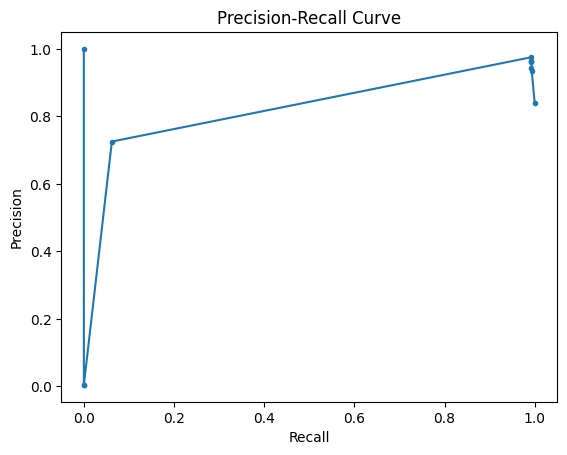

In [16]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, reconstruction_error_test)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

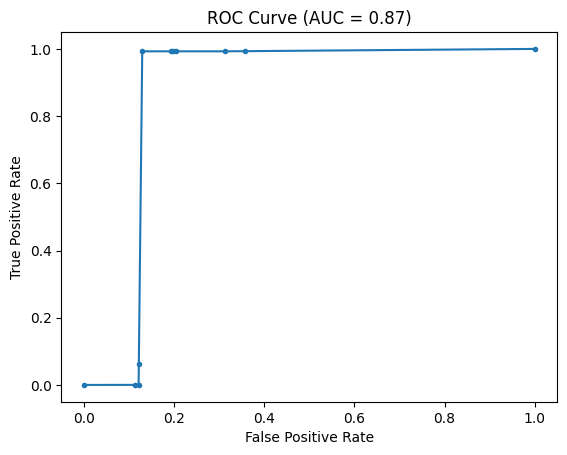

In [17]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, reconstruction_error_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, reconstruction_error_test)

# Plot the ROC curve
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (AUC = {roc_auc:.2f})')  # Display the AUC score on the title

# Show the plot
plt.show()